# Загрузка зависимостей

In [14]:
!nvidia-smi

Sat Sep 13 20:10:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050        Off |   00000000:03:00.0 Off |                  N/A |
| 37%   28C    P8             N/A /   75W |      10MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Всё, что нужно устанавливается через uv

In [1]:
!uv sync
!cd ManiSkill && uv pip install -e . && cd ..
!cd SimplerEnv && uv pip install -e . && cd ..

Resolved 90 packages in 0.70ms
Uninstalled 37 packages in 100ms
Installed 1 package in 16ms                                 
 - absl-py==2.3.1
 - arm-pytorch-utilities==0.4.3
 - cloudpickle==3.1.1
 - dacite==1.9.2
 - docstring-parser==0.17.0
 - farama-notifications==0.0.4
 - fast-kinematics==0.2.2
 - gitdb==4.0.12
 - gitpython==3.1.45
 - gymnasium==0.29.1
 - h5py==3.14.0
 - imageio==2.37.0
 - imageio-ffmpeg==0.6.0
 - lxml==6.0.1
 - mani-skill==3.0.0b20 (from file:///home/jezv/Projects/RL4VLA/ManiSkill)
 - markdown-it-py==4.0.0
 - mdurl==0.1.2
 - mplib==0.1.1
 - numpy==1.26.4
 + numpy==2.2.6
 - nvidia-ml-py==13.580.82
 - opencv-python==4.11.0.86
 - pynvml==13.0.1
 - pyperclip==1.9.0
 - pytorch-kinematics==0.7.5
 - pytorch-seed==0.2.0
 - rich==14.1.0
 - sapien==3.0.0b1
 - scipy==1.15.3
 - shtab==1.7.2
 - simpler-env==0.0.1 (from file:///home/jezv/Projects/RL4VLA/SimplerEnv)
 - smmap==5.0.2
 - tabulate==0.9.0
 - toppra==0.6.3
 - transforms3d==0.4.2
 - trimesh==4.8.1
 - typeguard==4.4.4
 -

Нужно в моём случае, потому что у меня первая видеокарта - 1050ti, которая не умеет работать с CUDA

In [2]:
!export CUDA_VISIBLE_DEVICES=1

# Required Step 1

In [6]:
# Задачи, на которых будем тестировать модель
tasks = ['PutCarrotOnPlateInScene-v1', 'PutOnPlateInScene25MultiCarrot-v1']

/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/random.py:187: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU1 NVIDIA GeForc

xyz_configs: (2104, 3, 3)
quat_configs: (4, 2, 4)


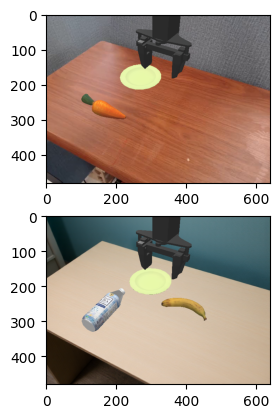

In [7]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

task_images = []

for i,task in enumerate(tasks):
    env = gym.make(task, 
               num_envs=1,
               obs_mode='rgb+segmentation')
    
    obs, reset_info = env.reset(seed = 42)
    task_images.append(obs['sensor_data']['3rd_view_camera']['rgb'].detach().cpu().numpy()[0])
    plt.subplot(len(tasks), 1, i+1)
    plt.imshow(task_images[-1])


task_images = np.array(task_images)
plt.show()

In [ ]:
task_questions = [
    'What objects do you see?',
    'What is the table made of?',
    'What is on the table?',
    'What can you eat on the table?',
    'What is closest to the edge of the table?',
    'What is most likely to fall off a table?'
]
task_answers = [
    ['I see a table, a plate, a carrot and a manipuletor.', 'I see a table, a plate, a banana, a bottle and a manipuletor.'],
    ['wood', 'Table made of something beige.'],
    ['There is a carrot and a plate on the table.', 'There is a banana, a bottle and a plate on the table'],
    ['I can eat a carrot.', 'I can eat a banana.'],
    ['A carrot', 'A bottle'],
    ['A carrot', 'A bottle']
]

In [7]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from bert_score import score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 27324.46it/s]
`torch_dtype` is deprecated! Use `dtype` instead!


## Рассчёт SR при помощи BertScore

In [9]:
for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        print(generated_texts[0])
        print(answer[i])
        results = score(generated_texts, [answer[i]], lang='en')
        print(results)


User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: Carrot and plate.
I see a table, a plate, a carrot and a manipuletor.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7479]), tensor([0.8471]), tensor([0.7944]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: Bottle, plate, banana, and a microscope.
I see a table, a plate, a banana, a bottle and a manipuletor.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7475]), tensor([0.8969]), tensor([0.8154]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is the table made of?
Assistant: Wood.
Table made of wood.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7079]), tensor([0.9137]), tensor([0.7977]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is the table made of?
Assistant: Wood.
Table made of something beige.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7108]), tensor([0.8661]), tensor([0.7808]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is on the table?
Assistant: Carrot and plate.
There is a carrot and a plate on the table.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7289]), tensor([0.9019]), tensor([0.8062]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is on the table?
Assistant: Bottle, plate, and bananas
There is a banana, a bottle and a plate on the table


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7361]), tensor([0.9016]), tensor([0.8105]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What can you eat on the table?
Assistant: Carrot.
I can eat a carrot.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7149]), tensor([0.9009]), tensor([0.7972]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What can you eat on the table?
Assistant: Banana.
I can eat a banana.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7141]), tensor([0.8979]), tensor([0.7955]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is closest to the edge of the table?
Assistant: Carrot.
A carrot


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6938]), tensor([0.8814]), tensor([0.7764]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is closest to the edge of the table?
Assistant: Bottle.
A bootle


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6935]), tensor([0.8148]), tensor([0.7493]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is most likely to fall off a table?
Assistant: Carrot.
A carrot


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6911]), tensor([0.8765]), tensor([0.7728]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is most likely to fall off a table?
Assistant: Banana.
A bootle


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6887]), tensor([0.8022]), tensor([0.7412]))


## Рассчёт SR при помощи SelfCheck

In [ ]:
for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )
        print(generated_texts[0].split('\n')[-1])
        print(answer[i])

        messages += [
            {
                "role": "assistant",
                "content": [
                    {"type": "text", 'text': generated_texts[0]}
                ]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", 'text': f"Right answer was: {answer[i]}. Do you think you answered correctly? Your answer does not have to match exactly, but semantically. Answer: [Yes/No]"}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        print(generated_texts[0])
        print(generated_texts[0].split('\n')[-1])

Assistant: Carrot and plate.
I see a table, a plate, a carrot and a manipuletor.
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: Carrot and plate.
User: Right answer was: I see a table, a plate, a carrot and a manipuletor..Do you think you answered correctly? Your answer does not have to match exactly, but semantically. Answer: [Yes/No]
Assistant: No.
Assistant: No.
Assistant: Bottle, plate, banana, and a microscope.
I see a table, a plate, a banana, a bottle and a manipuletor.
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><r

## Рассчёт SR при помощи ключевых слов

In [13]:
task_questions = [
    'What objects do you see?',
    'What is the table made of?',
    'What is on the table?',
    'What can you eat on the table?',
    'What is closest to the edge of the table?',
    'What is most likely to fall off a table?'
]
task_answers = [
    [('table', 'plate', 'carrot', 'manipulator'), ('table', 'plate', 'banana', 'bottle', 'manipulator')],
    [('wood'), ('wood')],
    [('carrot', 'plate'), ('banana', 'bottle', 'plate')],
    [('carrot'), ('banana')],
    [('carrot'), ('bottle')],
    [('carrot'), ('bottle')]
]

In [17]:
corrects = 0

for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        correct = True
        for keyword in answer[i]:
            correct &= keyword in generated_texts[0].split('\n')[-1].lower()
        if correct: corrects += 1

        print(correct)
        print(generated_texts[0].split('\n')[-1])
        print(answer[i])

SR = corrects / (len(task_questions)*len(task_images))
print('='*30)
print(f'{SR*100:.2f}%')

False
Assistant: Carrot and plate.
('table', 'plate', 'carrot', 'manipulator')
False
Assistant: Bottle, plate, banana, and a microscope.
('table', 'plate', 'banana', 'bottle', 'manipulator')
True
Assistant: Wood.
wood
True
Assistant: Wood.
wood
True
Assistant: Carrot and plate.
('carrot', 'plate')
True
Assistant: Bottle, plate, and bananas
('banana', 'bottle', 'plate')
True
Assistant: Carrot.
carrot
True
Assistant: Banana.
banana
True
Assistant: Carrot.
carrot
True
Assistant: Bottle.
bottle
True
Assistant: Carrot.
carrot
False
Assistant: Banana.
bottle
75.00%


| Task | Model | SR |
| --- | --- | --- |
| PutCarrotOnPlateInScene-v1 | SmolVLM | 75% |
| PutOnPlateInScene25MultiCarrot-v1 | SmolVLM | 75% |

# Required Step 1.1

In [3]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)

/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 25497.29it/s]
`torch_dtype` is deprecated! Use `dtype` instead!
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX 1050 which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
  

In [4]:
task_questions = [
    'What objects do you see?',
    'Describe a table',
    'What is on the table?',
    'What can you eat on the table?',
    'What is closest to the edge of the table?',
    'What is most likely to fall off a table?'
]

Сделаем генеративные ответы

In [5]:
from mani_skill.envs.sapien_env import BaseEnv

table_materials = [
    'wood',
    'plastic',
    'black',
    'gray',
    'wood',
    'wood',
    'yellow',
    'granite',
    'gray',
    'white',
    'granite',
    'pink',
    'wood',
    'grass',
    'wood',
    'colorful',
    'glass',
    'green',
    'pink',
    'stone',
    'wood'
]

eatable = ['001_carrot_simpler', '003_bread_1', '005_7up can_1', '006_zuchinni_1', '007_ketchup bottle_1', '008_watering can_1', '011_fast food cup_1', '013_banana_1', '014_hamburger_1', '016_BBQ sauce_1', '018_pepper_1', '020_potato_1', '021_baguette_1', '022_champagne glass_1', '024_onion_1']
eatable = set([obj.split('_')[1] for obj in eatable])

table_open_sides = [
    [2],
    [1,2],
    [1,2],
    [0,1,2],
    [1,2],
    [0,1,2],
    [0,1,2],
    [0,1,2],
    [1,2],
    [2],
    [0,1,2],
    [1,2],
    [0,1,2],
    [0,1,2],
    [0,1,2],
    [2],
    [0,1,2],
    [0,1,2],
    [2],
    [0,1,2],
    [0,1,2]
]


def get_objects(env: BaseEnv) -> list:
    objects = []
    objects.append(env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1])
    objects.append(env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1])
    if hasattr(env.unwrapped, 'select_extra_ids'):
        objects.append(env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1])
    return objects


def get_objects_all(env: BaseEnv) -> list:
    objects = get_objects(env)
    objects += ['manipulator', 'table']
    return objects


def get_table_material(env: BaseEnv) -> list:
    material = table_materials[env.unwrapped.select_overlay_ids[0]]
    return [material]


def get_eatable(env: BaseEnv) -> list:
    objects = get_objects(env)
    eatable_objects = set(objects) & eatable
    return list(eatable_objects)


def get_edge_distance(object: tuple[int, int]) -> tuple[int, int, int]:
    object = np.array(object) * np.array([640, 480])
    dotI = np.array([160, 71])
    dotII = np.array([69, 215])
    dotIII = np.array([0, 179])
    dotIV = np.array([0, 318])
    dotV = np.array([310,479])

    s1 = dotI - dotII
    edge1_distance = np.abs((np.cross(object, dotI) * s1)) / np.abs(s1)

    s2 = dotI - dotIII
    edge2_distance = np.abs((np.cross(object, dotI) * s2)) / np.abs(s2)

    s3 = dotIV - dotV
    edge3_distance = np.abs((np.cross(object, dotV) * s3)) / np.abs(s3)

    return edge1_distance, edge2_distance, edge3_distance


def get_closest_to_edge(env: BaseEnv) -> list:
    distances = {}
    objects_position = env.unwrapped.xyz_configs[env.unwrapped.select_pos_ids][:, :2]

    carrot_object_name = env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1]
    carrot_distance = np.min(get_edge_distance(objects_position[0]))
    distances[carrot_distance] = carrot_object_name

    plate_object_name = env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1]
    plate_distance = np.min(get_edge_distance(objects_position[1]))
    distances[plate_distance] = plate_object_name

    if hasattr(env.unwrapped, 'select_extra_ids'):
        extra_object_name = env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1]
        extra_distance = np.min(get_edge_distance(objects_position[2]))
        distances[extra_distance] = extra_object_name

    return [distances[min(distances.keys())]]


def get_fall_objects(env: BaseEnv) -> list:
    distances = {}
    objects_position = env.unwrapped.xyz_configs[env.unwrapped.select_pos_ids][:, :2]
    sides = table_open_sides[env.unwrapped.select_overlay_ids[0]]

    carrot_object_name = env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1]
    carrot_distance = np.array(get_edge_distance(objects_position[0]))[sides].min()
    distances[carrot_distance] = carrot_object_name

    plate_object_name = env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1]
    plate_distance = np.array(get_edge_distance(objects_position[1]))[sides].min()
    distances[plate_distance] = plate_object_name

    if hasattr(env.unwrapped, 'select_extra_ids'):
        extra_object_name = env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1]
        extra_distance = np.array(get_edge_distance(objects_position[2]))[sides].min()
        distances[extra_distance] = extra_object_name

    return [distances[min(distances.keys())]]

task_answers = [
    get_objects_all,
    get_table_material,
    get_objects,
    get_eatable,
    get_closest_to_edge,
    get_fall_objects
]

/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/sapien/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [9]:
from tqdm import tqdm
from collections import defaultdict
import gymnasium as gym
from mani_skill.envs import *

envs = [gym.make(task, 
        num_envs=1,
        obs_mode='rgb+segmentation') for task in ['PutOnPlateInScene25Main-v3', 'PutOnPlateInScene25MultiCarrot-v1']]

start_seed = 42 # Объявим начальный сид, чтоб потом детерменированно создавать среды для наилучшего воспроизведения
corrects = []
objects_stats = defaultdict(lambda: defaultdict(int))

for i in tqdm(range(500)):
    for env in envs:
        for question, answer_function in zip(task_questions, task_answers):
            obs, reset_info = env.reset(seed = start_seed + i)
            image = obs['sensor_data']['3rd_view_camera']['rgb'].detach().cpu().numpy()[0]

            keywords = answer_function(env)
            messages = [
                    {
                        "role": "user",
                        "content": [
                            {"type": "image"},
                            {"type": "text", 'text': question}
                        ]
                    }
                ]
            
            prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
            inputs = processor(text=prompt, images=[image], return_tensors="pt")
            inputs = inputs.to(DEVICE)
                
            generated_ids = model.generate(**inputs, max_new_tokens=500)
            generated_texts = processor.batch_decode(
                generated_ids,
                skip_special_tokens=True,
            )

            correct = True
            for keyword in keywords:
                done = keyword.lower() in generated_texts[0].split('\n')[-1].lower()
                if not done: objects_stats[question][keyword] += 1
                correct &= done
            corrects.append(correct)

print(f"SR: {(sum(corrects) / len(corrects))*100:.2f}%")
    

xyz_configs: (2104, 3, 3)
quat_configs: (4, 2, 4)


100%|██████████| 500/500 [1:34:19<00:00, 11.32s/it]

SR: 20.08%


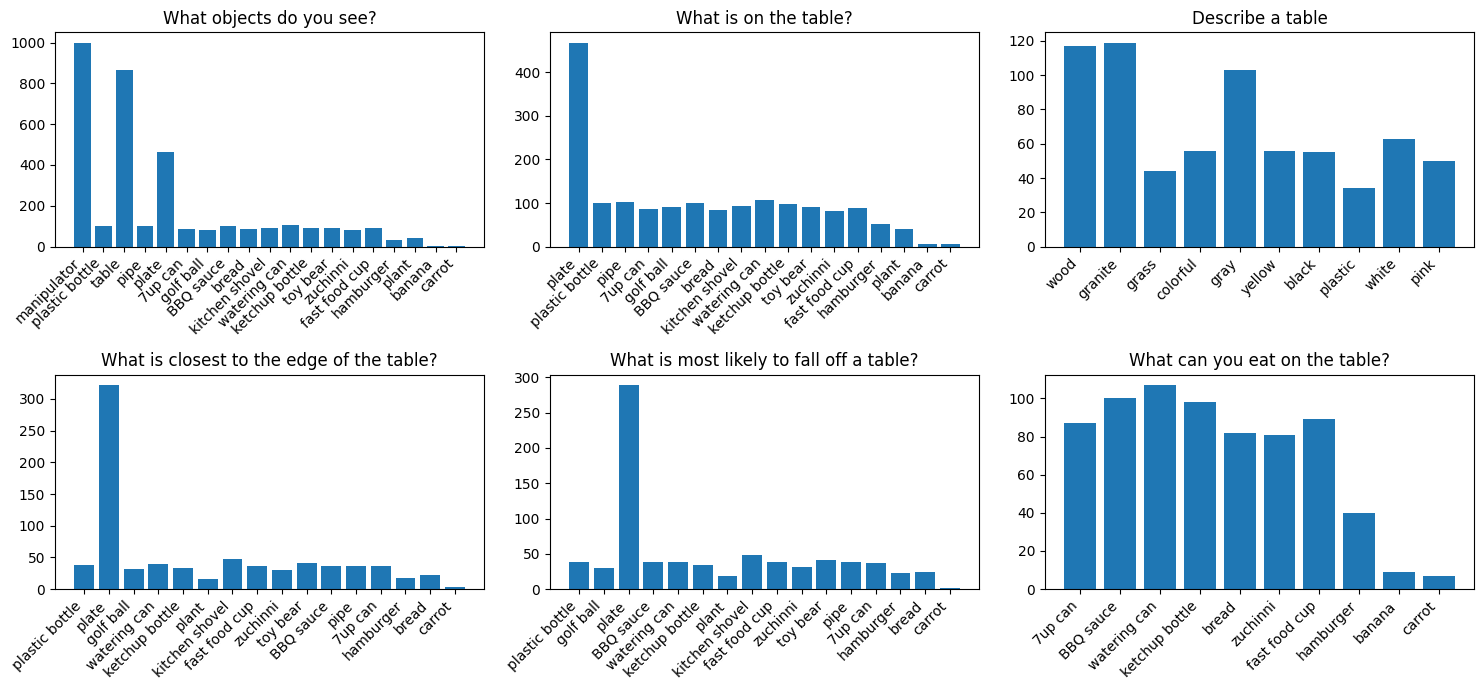

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

for i in range(2):
    for j in range(3):
        plt.subplot(2, 3, i*3+(j+1))
        question = list(objects_stats.keys())[i*3+j]
        plt.title(question)
        plt.xticks(rotation=45, ha='right')
        if not list(objects_stats[question].values()): continue
        plt.bar(objects_stats[question].keys(), objects_stats[question].values())
plt.tight_layout()
plt.show();

# Required Step 2

In [3]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)

/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 25343.23it/s]
`torch_dtype` is deprecated! Use `dtype` instead!
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX 1050 which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
  

In [1]:
import gymnasium as gym
from mani_skill.envs import *

task = 'PutOnPlateInScene25MultiCarrot-v1'
env = gym.make(task, 
               num_envs=1,
               obs_mode='rgb+segmentation')

/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/sapien/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


xyz_configs: (2104, 3, 3)
quat_configs: (4, 2, 4)


/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/random.py:187: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU1 NVIDIA GeForc

In [2]:
print(env.unwrapped.carrot_names)

['001_carrot_simpler', '002_kitchen shovel_1', '003_bread_1', '004_plastic bottle_1', '005_7up can_1', '006_zuchinni_1', '007_ketchup bottle_1', '008_watering can_1', '009_pipe_1', '010_toy bear_1', '011_fast food cup_1', '012_plant_1', '013_banana_1', '014_hamburger_1', '015_golf ball_1', '016_BBQ sauce_1', '017_travel cup_1', '018_pepper_1', '019_nonstop can_1', '020_potato_1', '021_baguette_1', '022_champagne glass_1', '023_kitchen spoon_1', '024_onion_1', '025_cup_1']


In [18]:
from tqdm import tqdm
from collections import defaultdict

start_seed = 42 # Объявим начальный сид, чтоб потом детерменированно создавать среды для наилучшего воспроизведения
corrects = []
objects_stats = defaultdict(int)

for i in tqdm(range(1000)):
    obs, reset_info = env.reset(seed = start_seed + i)
    image = obs['sensor_data']['3rd_view_camera']['rgb'].detach().cpu().numpy()[0]

    action_carrot = env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1]
    extra_carrot = env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1]
    plate = env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1]
    objects = [action_carrot, extra_carrot, plate]

    messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': 'What objects are in the scene?'}
                ]
            }
        ]
    
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[image], return_tensors="pt")
    inputs = inputs.to(DEVICE)
        
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )

    correct = True
    for keyword in objects:
        done = keyword.lower() in generated_texts[0].split('\n')[-1].lower()
        if not done: objects_stats[keyword] += 1
        correct &= done
    corrects.append(correct)

print(f"SR: {(sum(corrects) / len(corrects))*100:.2f}%")
    

100%|██████████| 1000/1000 [18:46<00:00,  1.13s/it]

SR: 2.90%


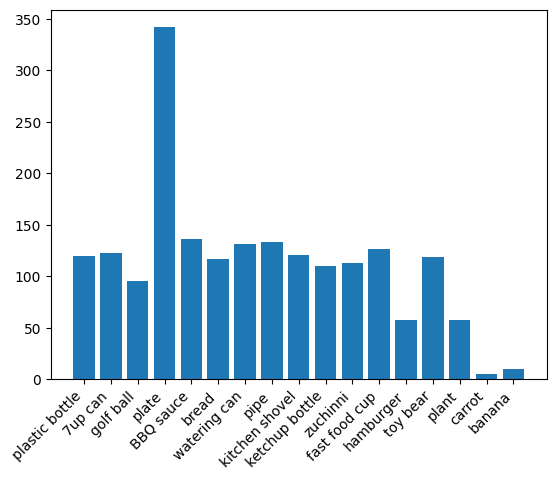

In [19]:
import matplotlib.pyplot as plt

plt.xticks(rotation=45, ha='right')
plt.bar(objects_stats.keys(), objects_stats.values());